In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
from tqdm.contrib.itertools import product

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

In [3]:
mean = np.zeros((2,))
cov = np.array([[1, 0.5], [0.5, 1]])
N = 1_000

samples = sps.multivariate_normal.rvs(mean=mean, cov=cov, size=N)
samples

array([[-0.6629762 , -0.21003911],
       [ 0.98199168,  2.74100853],
       [ 1.41444979,  0.23729398],
       ...,
       [ 0.64717078, -0.20477392],
       [ 0.89836956, -0.32570331],
       [ 0.40690828, -0.85613754]])

### a. Run SGD

In [4]:
dim =  2

In [5]:
def gen_P() -> np.ndarray:
    """Generate matrix P so that its inverse matrix is numerically stable.

    Returns:
        np.ndarray: matrix P
    """
    b, c = np.random.rand(), np.random.rand()
    d = np.random.rand() + 0.5
    a = (0.5 + b * c) / d

    return np.array([[a, b], [c, d]])

In [6]:
def gradient(P: np.ndarray, X: np.ndarray):
    xsum = 0
    n = X.shape[0]
    for i in range(n):
        xsum += X[i][:, None] @ X[i][None, :]

    return 0.5 * (n * np.linalg.inv(P) - xsum)

In [7]:
def log_ll(P: np.ndarray, X: np.array):
    n, _ = X.shape

    s = 0
    for i in range(n):
        xi = X[i][:, None]
        s += xi.T @ P @ xi

    value = -n * np.log(2 * np.pi) + n/2 * np.log(np.linalg.det(P)) - 1/2 * s

    return value

In [8]:
def update(
    Pinit: np.ndarray,
    X: np.ndarray,
    lr: float,
    num_iter: int = 10_000
) -> tuple:
    P = Pinit
    objectives = []
    for _ in range(num_iter):
        P = P + lr * gradient(P, X)

        objectives.append(log_ll(P, X).item())

    return P, objectives

In [9]:
X = np.random.normal(0, 1, (5, 2))
list_Pinit = [('P1', gen_P()), ('P2', gen_P()), ('P3', gen_P())]
list_lr = [1e-5, 1e-4, 1e-3]

In [10]:
dict_P_final = {}
list_objs = []

for tup_Pinit, lr in product(list_Pinit, list_lr):
    name, Pinit = tup_Pinit
    
    P_final, objectives = update(Pinit, X, lr)

    dict_P_final[(name, lr)] = P_final

    list_objs.extend([{'name': name, 'lr': lr, 'n': i+1, 'objective': obj} for i, obj in enumerate(objectives)])

  0%|          | 0/9 [00:00<?, ?it/s]

### b. Figures

In [11]:
df_objs = pd.DataFrame.from_records(list_objs)

df_objs.head()

,name,lr,n,objective
0,P1,0.00001,1,-20.049719
1,P1,0.00001,2,-20.049158
2,P1,0.00001,3,-20.048598
3,P1,0.00001,4,-20.048038
4,P1,0.00001,5,-20.047478


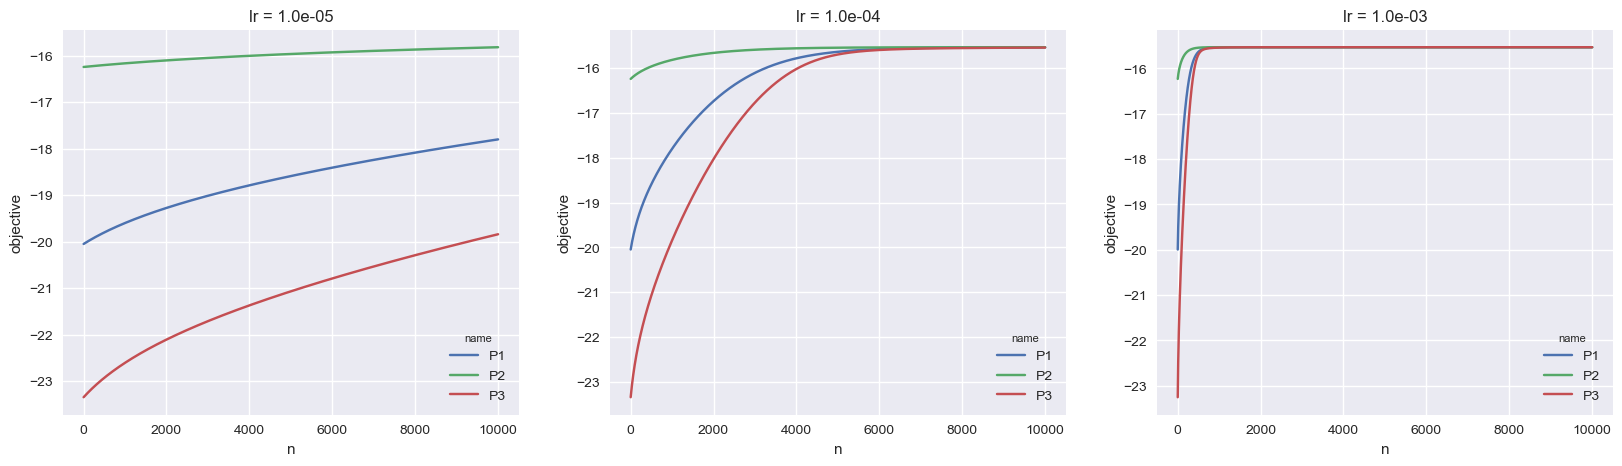

In [12]:
fig = plt.figure(figsize=(20, 5))



for i, lr in enumerate(list_lr):
    ax = fig.add_subplot(1, 3, i+1)
    df_lr = df_objs[df_objs['lr'] == lr]

    sns.lineplot(df_lr, x='n', y='objective', hue='name')
    ax.set_title(f"lr = {lr:.1e}")

### c. Estimation error

In [13]:
for k, P_pred in dict_P_final.items():
    Pinit_name, lr = k

    norm = np.square(np.linalg.norm(np.linalg.inv(cov) - P_pred))

    print(f"Initial {Pinit_name} - lr = {lr:.1e} -> norm = {norm:.5f}")

Initial P1 - lr = 1.0e-05 -> norm = 3.16071
Initial P1 - lr = 1.0e-04 -> norm = 1.34845
Initial P1 - lr = 1.0e-03 -> norm = 1.29711
Initial P2 - lr = 1.0e-05 -> norm = 2.05232
Initial P2 - lr = 1.0e-04 -> norm = 1.30905
Initial P2 - lr = 1.0e-03 -> norm = 1.29711
Initial P3 - lr = 1.0e-05 -> norm = 2.93343
Initial P3 - lr = 1.0e-04 -> norm = 1.37994
Initial P3 - lr = 1.0e-03 -> norm = 1.29711
